In [ ]:
# NumPy 호환성 문제 해결을 위한 올바른 설치 순서

# 1단계: 핵심 패키지들을 먼저 NumPy 1.x와 호환되도록 설치
!pip install --force-reinstall "numpy<2.0"
!pip install --force-reinstall pandas
!pip install --force-reinstall scikit-learn

# 2단계: PyTorch 관련 패키지들 (NumPy 호환 버전)
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu --no-deps
!pip install --force-reinstall torch torchvision

# 3단계: 기타 필요한 패키지들
!pip install -q kaggle
!pip install -q kagglehub
!pip install -q albumentations
!pip install -q ultralytics
!pip install -q opencv-python
!pip install -q pycocotools
!pip install -q matplotlib
!pip install -q lpips
!pip install -q pytorch-fid
!pip install -q torch-fidelity
!pip install -q scipy

# 4단계: Google API 관련
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

print("✅ 모든 라이브러리 설치 완료!")
print("🔄 커널을 재시작한 후 다음 셀을 실행하세요.")

In [1]:
# 기본 라이브러리

# --- Scikit-learn: 데이터 전처리, 모델, 평가 ---
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import (
    fetch_california_housing, load_iris, make_moons, make_circles,
    load_breast_cancer, load_wine
)
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import average_precision_score

# --- 기타 라이브러리 ---
import cv2
from PIL import Image
from PIL import ImageFilter
from PIL import ImageDraw
import albumentations as A
import IPython.display
#from tqdm import tqdm
from tqdm.notebook import tqdm

# --- PyTorch: 딥러닝 관련 ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as TF
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from collections import OrderedDict
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask

# --- 기타 ---
import re
import os
import sys
import copy
import json
import math
import random
import yaml
import shutil
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from datetime import datetime
from datetime import timezone, timedelta
import pytz
__kst = pytz.timezone('Asia/Seoul')

# GPU 설정
__device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
__device_cpu = torch.device('cpu')

  # 재현 가능한 결과를 위해
np.random.seed(42)
torch.manual_seed(42)
if __device == 'cuda':
    torch.cuda.manual_seed_all(42)

print(f"라이브러리 로드 완료 사용장치:{__device}")

c:\Users\sw1\anaconda3\envs\py310_recommand_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


라이브러리 로드 완료 사용장치:cpu


In [5]:
!pip install -q torch torchvision matplotlib pillow requests
import requests
import io
from diffusers import StableDiffusionPipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]



In [2]:
def alternative_face_generation(pipe, prompt, negative_prompt=None, seed=42,
                              num_inference_steps=30, guidance_scale=7.5,
                              save_path=None, show_image=True):
    """확장된 Stable Diffusion 이미지 생성 함수"""

    try:
        # 기본 negative prompt 설정
        if negative_prompt is None:
            negative_prompt = "blurry, low quality, bad anatomy, deformed, extra limbs, bad hands, bad face, bad eyes, extra fingers, cartoon, anime, nsfw, inappropriate"

        # 랜덤 시드 고정
        generator = torch.Generator(device=pipe.device).manual_seed(seed)

        print(f"이미지 생성 중... (시드: {seed})")
        print(f"프롬프트: {prompt}")
        if negative_prompt:
            print(f"네거티브: {negative_prompt}")

        # 이미지 생성
        image = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator,
            height=512,
            width=512
        ).images[0]

        # 이미지 저장
        if save_path:
            image.save(save_path)
            print(f"이미지 저장됨: {save_path}")

            # 메타데이터 저장
            metadata = {
                "prompt": prompt,
                "negative_prompt": negative_prompt,
                "seed": seed,
                "steps": num_inference_steps,
                "guidance_scale": guidance_scale
            }

            import json
            metadata_path = save_path.replace('.png', '_metadata.json')
            with open(metadata_path, 'w', encoding='utf-8') as f:
                json.dump(metadata, f, indent=2, ensure_ascii=False)

        # 이미지 표시
        if show_image:
            plt.figure(figsize=(4, 4))
            plt.imshow(image)
            plt.title(f"Generated (Seed: {seed})", fontsize=14)
            plt.axis('off')
            plt.show()

        print("이미지 생성 완료!")
        return image

    except Exception as e:
        print(f"생성 실패: {e}")
        return None

# 배치 생성 함수 추가
def batch_generate_images(pipe, prompts, base_negative=None, seeds=None, save_folder=None):
    """여러 프롬프트로 배치 생성"""

    import os
    if save_folder is not None:
        os.makedirs(save_folder, exist_ok=True)

    if seeds is None:
        seeds = list(range(42, 42 + len(prompts)))

    results = []

    for i, (prompt, seed) in enumerate(zip(prompts, seeds)):
        print(f"생성 seed{seed} {i+1}/{len(prompts)} ===")

        save_path = None
        if save_folder is not None:
            save_path = f"{save_folder}/image_{i+1:03d}_seed_{seed}.png"

        image = alternative_face_generation(
            pipe=pipe,
            prompt=prompt,
            negative_prompt=base_negative,
            seed=seed,
            save_path=save_path,
            show_image=True
        )

        if image:
            results.append({
                "prompt": prompt,
                "seed": seed,
                "image": image,
                "path": save_path
            })

    return results

# # 단일 이미지 생성
# prompt = "young Asian woman traveling, casual travel outfit, natural smile, professional photography"
# negative = "blurry, low quality, bad anatomy, deformed, cartoon, nsfw"

# image = alternative_face_generation(
#     pipe=pipe,
#     prompt=prompt,
#     negative_prompt=negative,
#     seed=123,
#     save_path="traveler_portrait.png"
# )

# # 배치 생성 예시
# prompts = [
#     "young Asian woman, casual style, friendly expression",
#     "Asian female tourist, backpack, city background",
#     "Asian woman in twenties, natural makeup, soft lighting"
# ]

# results = batch_generate_images(
#     pipe=pipe,
#     prompts=prompts,
#     base_negative="blurry, low quality, bad anatomy, cartoon, nsfw",
#     seeds=[1, 2, 3],
#     save_folder="asian_portraits"
# )

In [3]:
# prompts = [
#     "young Asian woman, casual style, friendly expression",
#     "Asian female tourist, backpack, city background",
#     "Asian woman in twenties, natural makeup, soft lighting"
# ]
# negative = "blurry, low quality, bad anatomy, deformed, cartoon, nsfw"

# results = batch_generate_images(
#     pipe=pipe,
#     prompts=prompts,
#     base_negative=negative,
#     seeds=[1],
#     save_folder="asian_portraits"
# )

이미지 생성 중... (시드: 54947624)
프롬프트: single inverted triangular diamond floating in center of dark room, levitating gemstone, sparkling brilliantly, magical lighting, crystalline reflections, floating in mid-air
네거티브: realistic, photorealistic, dark colors, modern setting, realistic animals, live action, poor quality, blurry


100%|██████████| 30/30 [07:20<00:00, 14.68s/it]


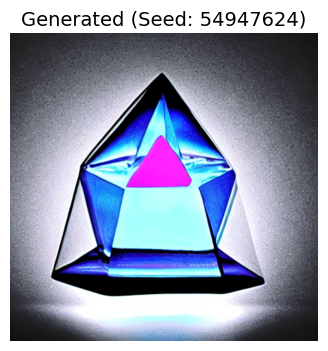

이미지 생성 완료!


In [6]:
import random

# 93501056
#prompt = "Asian woman in her teen, full body, natural makeup, soft lighting"
#negative_prompt = "blurry, low quality, bad anatomy, deformed, cartoon"

prompt = "single inverted triangular diamond floating in center of dark room, levitating gemstone, sparkling brilliantly, magical lighting, crystalline reflections, floating in mid-air"
#negative_prompt = "blurry, low quality, multiple objects, support wires, strings, stands, ground contact, poor reflections"
negative_prompt = "realistic, photorealistic, dark colors, modern setting, realistic animals, live action, poor quality, blurry"

prompt = prompt.lower()
negative_prompt = negative_prompt.lower()
image = alternative_face_generation(
    pipe=pipe,
    prompt=prompt,
    negative_prompt=negative_prompt,
    seed=random.randint(1, 99999999),
    #seed=93501056,
    save_path=None
)

In [ ]:
cliff_beach_prompt = "dramatic coastal cliff overlooking crystal clear ocean, refreshing sea breeze, waves gently crashing below, beautiful natural seascape, professional landscape photography, high quality"
cliff_negative = "blurry, low quality, dark, gloomy, polluted, artificial, oversaturated, people, buildings"

image = alternative_face_generation(
    pipe=pipe,
    prompt=cliff_beach_prompt,
    negative_prompt=cliff_negative,
    seed=1101,
    save_path="cliff_ocean_view.png"
)

In [ ]:
# 1단계: 기본 품질 문제
base_negative = "blurry, low quality, pixelated, jpeg artifacts"

# 2단계: 해부학적 문제
anatomy_negative = "bad anatomy, deformed, extra limbs, bad hands, extra fingers, bad face"

# 3단계: 스타일 제외
style_negative = "cartoon, anime, drawing, painting, 3d render"

# 4단계: 부적절한 콘텐츠
safety_negative = "nsfw, inappropriate, nude, explicit"

# 통합
negative = f"{base_negative}, {anatomy_negative}, {style_negative}, {safety_negative}"
prompts=['{"cartoon, anime, drawing, painting, sketch, 3d render, artificial"}',]

prompts = "random"
negative = "blurry, low quality, bad hands, deformed, artificial, staged"

results = batch_generate_images(
    pipe=pipe,
    prompts=prompts,
    base_negative=negative,
    seeds=[1],
    save_folder=None
)